## Import Librairies ##

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from datetime import datetime
import time 



colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']


## Preprocessing Data ##

In [8]:
labels_of_tumor = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
print(labels_of_tumor)

['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']


In [18]:
from PIL import Image
#build preprocessing class
class Preprocessing():
    
    def __init__(self , img_size):
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.img_size = img_size
        
    def getTraining(self, labels_of_tumor):
        for i in labels_of_tumor:
            path_training = os.path.join('./brain-tumor-class-mri','Training' , i)
            for j in tqdm(os.listdir(path_training)):
                img = cv2.imread(os.path.join(path_training , j)) #get the name of the folder path
                img = cv2.resize(img , (self.img_size , self.img_size)) #resizing image to image size parameter
                self.X_train.append(img)
                self.y_train.append(i)

    def getTesting(self, labels_of_tumor):
        for i in labels_of_tumor:
            path_testing = os.path.join('./brain-tumor-class-mri','Testing' , i)
            for j in tqdm(os.listdir(path_testing)):
                img = cv2.imread(os.path.join(path_testing , j)) #get the name of the folder path
                img = cv2.resize(img , (self.img_size , self.img_size)) #resizing image to image size parameter
                self.X_train.append(img)
                self.y_train.append(i)
                
    def returnSplitArrayOfTrain_Test(self):
        self.X_train = np.array(self.X_train)        
        self.y_train = np.array(self.y_train)
        self.X_train, self.y_train = shuffle(self.X_train,self.y_train, random_state=101)
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(self.X_train,self.y_train, test_size=0.1,random_state=101)
        print(self.X_train.shape , self.y_train.shape, self.X_test.shape , self.y_test.shape)
        return self.X_train , self.y_train, self.X_test , self.y_test
    
    def oneHotEncoding(self , y_train, y_test, labels_of_tumor): #Performing One Hot Encoding on the labels after converting it into numerical values
        #Training
        y_train_nw = []
        for i in y_train:
            y_train_nw.append(labels_of_tumor.index(i))
        self.y_train = y_train_nw
        self.y_train = tf.keras.utils.to_categorical(self.y_train)
        
        #Testing
        y_test_nw = []
        for j in y_test:
            y_test_nw.append(labels_of_tumor.index(j))
        self.y_test = y_test_nw
        self.y_test = tf.keras.utils.to_categorical(self.y_test)
        
        return self.y_train, self.y_test
        


## Build Model Class with Transfer Learning EfficientNetB0 and VGG 16##

In [35]:
#Build Transfert Learning Model 

class buildModel():
    
    def __init__(self): 
        
        #init based EfficientNetB0 Model 
        self.efficienNetBasedModel = None
        self.model = None
        
    def buildModel(self , model_type , image_size): 
        
        #EfficientNetB0 model which will use the weights from the ImageNet dataset.
        if "EfficientNetB0" == model_type:
            self.efficienNetBasedModel = EfficientNetB0(
                                                weights='imagenet',
                                                include_top=False,
                                                input_shape=(image_size,image_size,3))
            
            
        #EfficientNetB0 model which will use the weights from the ImageNet dataset.
        if "VGG16" == model_type:
            self.efficienNetBasedModel = VGG16(
                                                weights='imagenet',
                                                include_top=False,
                                                input_shape=(image_size,image_size,3))
        self.model = self.efficienNetBasedModel.output
        self.model = tf.keras.layers.GlobalAveragePooling2D()(self.model)
        self.model = tf.keras.layers.Dropout(rate=0.5)(self.model)
        self.model = tf.keras.layers.Dense(4,activation='softmax')(self.model)
        self.model = tf.keras.models.Model(inputs=self.efficienNetBasedModel.input, outputs = self.model)
        
        return self.model if self.model != None else "undefined"
    
    def training(self , loss, optimize ,epochs_number,batch_size, xtrain, ytrain, model_type):
        
        tensorboard = TensorBoard(log_dir = 'logs')
        checkpoint = ModelCheckpoint("brain_tumor_detection.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
        self.model.compile(loss=loss,optimizer = optimize , metrics= ['accuracy'])
        start = datetime.now() 
        model_history = self.model.fit(xtrain,ytrain,validation_split=0.1, epochs =epochs_number, verbose=1, 
                       batch_size=batch_size,callbacks=[tensorboard,checkpoint,reduce_lr])
        stop = datetime.now()
        #Execution time of the model 
        execution_time = stop-start
        print("CNN execution time is: ", execution_time)
        t = time.time()
        
        file_model_path = "Best_Model_Save"
        if model_type == "EfficientNetB0":
            file_model_path = 'Brain_Tumor_TL_EfficientNetB0'+str(epochs_number)+'epochs.h5'.format(int(t))
            dataFrameScores = pd.DataFrame(model_history.history)
            with open('Brain_Tumor_TL_EfficientNetB0.csv', mode='w') as f:
                dataFrameScores.to_csv(f)
            
        elif model_type == "VGG16":
            file_model_path = 'Brain_Tumor_TL_VGG16'+str(epochs_number)+'epochs.h5'.format(int(t))
            dataFrameScores = pd.DataFrame(model_history.history)
            with open('Brain_Tumor_TL_VGG16.csv', mode='w') as f:
                 dataFrameScores.to_csv(f)
            
        
            
        print("Save Model Path : " , file_model_path)
        self.model.save(file_model_path)
        
        return self.model



In [33]:
#init instance of Preprocessing class
obj_processing = Preprocessing(150)
#get training and testing folders
obj_processing.getTraining(labels_of_tumor) #Training
obj_processing.getTesting(labels_of_tumor)  #Testing
X_train , y_train , X_test, y_test = obj_processing.returnSplitArrayOfTrain_Test() #get Array 
#print(y_train.shape)

100%|████████████████████████████████████████████████████| 74/74 [00:00<00:00, 309.63it/s]


(2938, 150, 150, 3) (2938,) (327, 150, 150, 3) (327,)


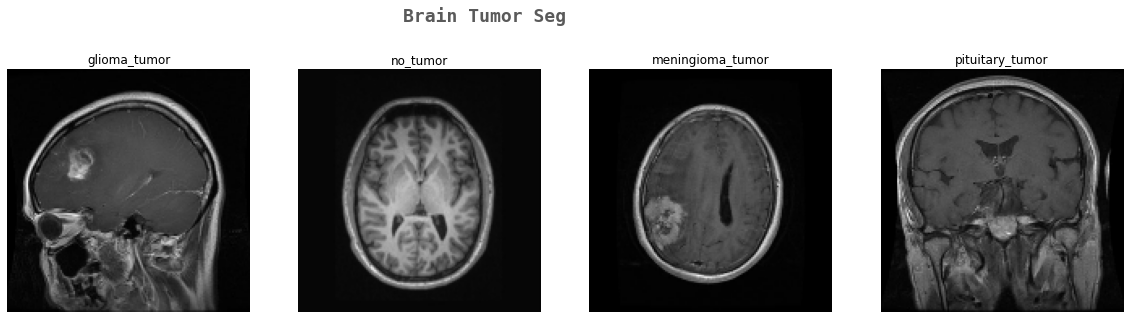

In [34]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Brain Tumor Seg',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels_of_tumor:
    j=0
    while True :
        #print(y_train[j])
        #print(i)
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1



### Performing One Hot Encoding  ###


In [36]:
y_train , y_test = obj_processing.oneHotEncoding(y_train , y_test , labels_of_tumor)



### Transfer Learning


In [37]:
#call Model 
model = buildModel()
model_generated = model.buildModel('EfficientNetB0' , obj_processing.img_size)
model_generated.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 150, 150, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 150, 150, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_3[0][0]            
____________________________________________________________________________________________

In [38]:
trained_model = model.training('categorical_crossentropy', 'Adam' ,12, 32 ,X_train, y_train,'EfficientNetB0')

2022-09-18 02:53:48.955020: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-18 02:53:48.955352: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-18 02:53:48.959874: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/12


2022-09-18 02:53:56.763251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 20:18 - loss: 1.6612 - accuracy: 0.0625

2022-09-18 02:54:04.099356: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-18 02:54:04.099385: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/83 [..............................] - ETA: 6:01 - loss: 1.5736 - accuracy: 0.1875 

2022-09-18 02:54:09.085714: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-18 02:54:09.133962: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-18 02:54:09.171229: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_18_02_54_09
2022-09-18 02:54:09.178751: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_18_02_54_09/MacBook-Pro-de-ZAHR-EDDINE.local.trace.json.gz
2022-09-18 02:54:09.215314: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_18_02_54_09
2022-09-18 02:54:09.216816: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_09_18_02_54_09/MacBook-Pro-de-ZAHR-EDDINE.local.memory_profile

83/83 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8313

2022-09-18 02:54:59.385750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 73s 712ms/step - loss: 0.4481 - accuracy: 0.8313 - val_loss: 0.4908 - val_accuracy: 0.8537

Epoch 00001: val_accuracy improved from -inf to 0.85374, saving model to brain_tumor_detection.h5
Epoch 2/12
83/83 [==============================] - 77s 914ms/step - loss: 0.2190 - accuracy: 0.9285 - val_loss: 0.5233 - val_accuracy: 0.8605

Epoch 00002: val_accuracy improved from 0.85374 to 0.86054, saving model to brain_tumor_detection.h5
Epoch 3/12
83/83 [==============================] - 74s 869ms/step - loss: 0.1408 - accuracy: 0.9512 - val_loss: 0.8911 - val_accuracy: 0.7313

Epoch 00003: val_accuracy did not improve from 0.86054
Epoch 4/12
83/83 [==============================] - 80s 898ms/step - loss: 0.0916 - accuracy: 0.9686 - val_loss: 0.9335 - val_accuracy: 0.7857

Epoch 00004: val_accuracy did not improve from 0.86054

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [===========================

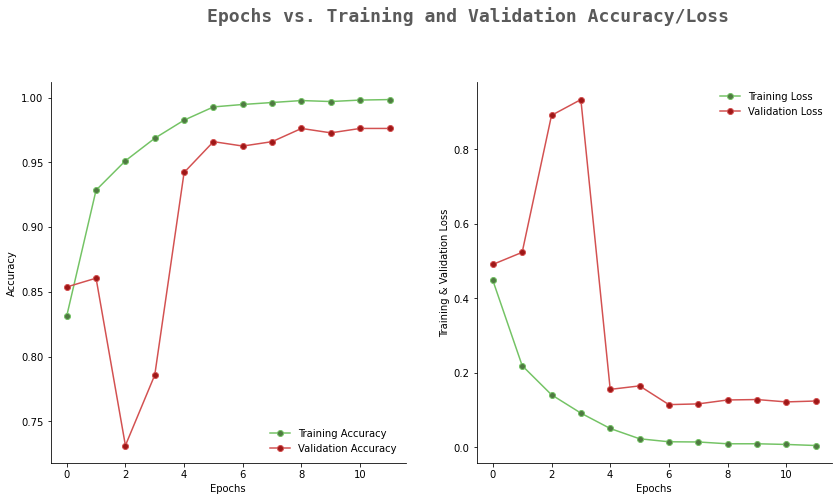

In [39]:

history = trained_model.history

filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()



In [40]:
pred = trained_model.predict(X_test)
pred = np.argmax(pred,axis=1)
yTestNew = np.argmax(y_test,axis=1)

2022-09-18 03:28:28.097912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [41]:

print(classification_report(yTestNew,pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96        94
           1       0.98      1.00      0.99        52
           2       0.96      0.96      0.96        91
           3       0.99      0.99      0.99        90

    accuracy                           0.97       327
   macro avg       0.97      0.98      0.97       327
weighted avg       0.97      0.97      0.97       327



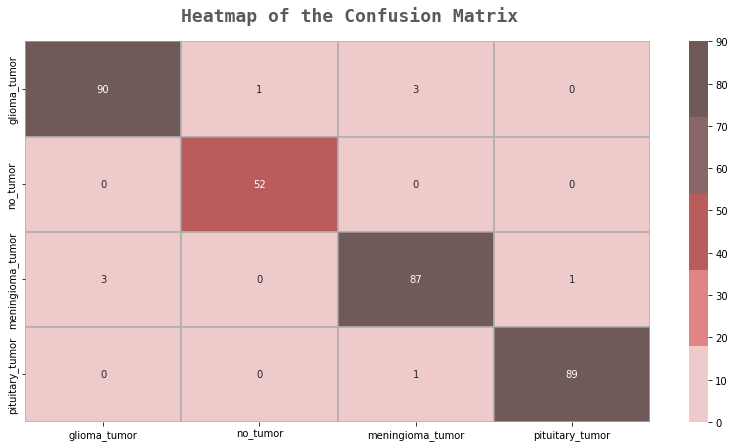

In [43]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(yTestNew,pred),ax=ax,xticklabels=labels_of_tumor,yticklabels=labels_of_tumor,annot=True,
           cmap=colors_red[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()


In [60]:
def img_pred(upload):
    
 
    img = cv2.imread(os.path.join('./brain-tumor-class-mri/' , 'mypredict.jpg'))
    plt.figure(figsize=(5, 5))
    plt.imshow( img, cmap='gray' )
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = trained_model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'MRI image / The Model predicts that it is a {p}')
        
        
    


The model predicts that there is no tumor


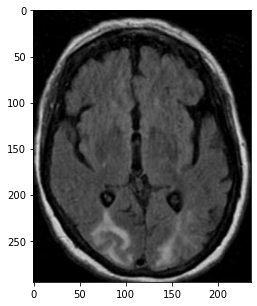

In [61]:
img_pred(None)


In [35]:


button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])